# 4. Use Case on Comparing Networks

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. *[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)*
3. *[Canonical Models](3_Basics_CanonMods.ipynb)*
4. **[Comparing Networks - Part I](4.1_UseCase_CompareNets_Part1.ipynb)**
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_UseCase_WeighteNets.ipynb)* 

---------------------

### Outline of use case

Goal is to reproduce the Figure 3 of [Zamora-López and Gilson (2024) Chaos](https://doi.org/10.1063/5.0202241). It illustrates that normalizing connectivity matrices by their largest eigenvalue ($A' = A \,/\, \lambda_{max}$) aligns their time-scales, allowing their properties to be comparable.

* Generate four graphs of different sizes and densities (using the same generative model).
* Compute and visualize basic properties of the four networks.
* Normalize by their $\lambda_{max}$ and recompute the properties.

The example here uses the leaky-cascade canonical model $\dot{\mathbf{x}} = - \mathbf{x} \,/\, \tau + A \mathbf{x}$, with *τ* being a leakage time-constant controling for the rate of dissipation through the nodes.

---------------------

## Import libraries

In [ ]:
# Library GAlib is used for generating the graphs
try:
    import galib
except ImportError:
    %pip install git+https://github.com/gorkazl/pyGAlib.git@master    

In [1]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg

import galib
import sireneta as sna


In [2]:
# Enter some plotting options to control visualization
%matplotlib inline
# Define the colors for plotting later
cols = ['deepskyblue', '#1f77b4', 'red', '#d62728']
# Define the default scale for the plots
plt.rcParams['figure.dpi'] = 72

<br>

## 1. Generate four networks: same architecture, different sizes / densities

Begin by choosing the class of networks to generate, among three graph models:
- **Random**: Random graph of $G(N,L)$ class, with uniform probability and prescribed number of links *L*.
- **Lattice**: A 1-dimensional ring lattice of *N* nodes, each connected to _2*z_ first neighbours.
- **ScaleFree**: Random graph with scale-free-like degree distribution. For the small sizes here employed (*N ≤ 500* nodes) the resulting degree distribution will be skewed but not fully scale-free.

In [3]:
netcase = 'Random'  # 'Random', 'Lattice', 'ScaleFree'

The four networks will be generated from the same graph model but with different sizes and densities, as follows:

* **net1** : small ( *N = 200* ) and sparse ( *ρ = 0.06* ).
* **net2** : small ( *N = 200* ) and dense ( *ρ = 0.1* ).
* **net3** : large ( *N = 500* ) and sparse ( *ρ = 0.06* ).
* **net4** : large ( *N = 500* ) and dense ( *ρ = 0.1* ).

In [4]:
# Create four networks, combining two sizes and two density options
N1 = 200
N2 = 500
dens1 = 0.06
dens2 = 0.1
L1s = int(round( 0.5*dens1*N1*(N1-1) ))
L1d = int(round( 0.5*dens2*N1*(N1-1) ))
L2s = int(round( 0.5*dens1*N2*(N2-1) ))
L2d = int(round( 0.5*dens2*N2*(N2-1) ))

if netcase=='Random':
    net1 = galib.models.RandomGraph(N1, L1s).astype(float64)
    net2 = galib.models.RandomGraph(N1, L1d).astype(float64)
    net3 = galib.models.RandomGraph(N2, L2s).astype(float64)
    net4 = galib.models.RandomGraph(N2, L2d).astype(float64)
elif netcase=='Lattice':
    z1s = 6; z1d = 10
    z2s = 15; z2d = 25
    net1 = galib.models.Lattice1D(N1, z1s).astype(float64)
    net2 = galib.models.Lattice1D(N1, z1d).astype(float64)
    net3 = galib.models.Lattice1D(N2, z2s).astype(float64)
    net4 = galib.models.Lattice1D(N2, z2d).astype(float64)
elif netcase=='ScaleFree':
    net1 = galib.models.ScaleFreeGraph(N1, L1s).astype(float64)
    net2 = galib.models.ScaleFreeGraph(N1, L1d).astype(float64)
    net3 = galib.models.ScaleFreeGraph(N2, L2s).astype(float64)
    net4 = galib.models.ScaleFreeGraph(N2, L2d).astype(float64)

# Make sure the networks are connected
indeg1 = net1.sum(axis=0);  outdeg1 = net1.sum(axis=1)
indeg2 = net2.sum(axis=0);  outdeg2 = net2.sum(axis=1)
indeg3 = net3.sum(axis=0);  outdeg3 = net3.sum(axis=1)
indeg4 = net4.sum(axis=0);  outdeg4 = net4.sum(axis=1)
assert 0 not in [indeg1.min(), indeg2.min(), indeg3.min(), indeg4.min()], 'Disconnected graph found. Try again or increase density.'


### Compute and compare their eigenvalues

In [5]:
# Definition for later use. Getting the eigenvalue with largest norm.
def SpectralRadius(eigenvalues):
    """Finds the eigenvalue with largest norm in the imaginary space."""
    
    N = len(eigenvalues)
    evnorms = np.zeros(N, float64)
    for i in range(N):
        evnorms[i] = numpy.linalg.norm(eigenvalues[i])
    maxradius = evnorms.max()

    return maxradius

In [6]:
# Compute the eigenvalues of the four networks
evs1 = numpy.linalg.eigvals(net1)
evs2 = numpy.linalg.eigvals(net2)
evs3 = numpy.linalg.eigvals(net3)
evs4 = numpy.linalg.eigvals(net4)

# Find the largest eigenvalues, and the corresponding critical τ for each network
evmax1 = SpectralRadius(evs1); taumax1 = 1.0 / evmax1
evmax2 = SpectralRadius(evs2); taumax2 = 1.0 / evmax2
evmax3 = SpectralRadius(evs3); taumax3 = 1.0 / evmax3
evmax4 = SpectralRadius(evs4); taumax4 = 1.0 / evmax4

# Print some feedback: spectral radius and corresponding critical 'tau's
print( '\tSpectral radius\t\tLargest tau' )
print( 'net #1:   %3.5f\t\t%2.5f'  %(evmax1, taumax1) )
print( 'net #2:   %3.5f\t\t%2.5f'  %(evmax2, taumax2) )
print( 'net #3:   %3.5f\t\t%2.5f'  %(evmax3, taumax3) )
print( 'net #4:   %3.5f\t\t%2.5f'  %(evmax4, taumax4) )


	Spectral radius		Largest tau
net #1:   13.03735		0.07670
net #2:   20.86262		0.04793
net #3:   30.90200		0.03236
net #4:   50.88738		0.01965


As expected, the spectral radius (largest eigenvalue $\lambda_{max}$) of the adjacency matrices *A* grows with their sizes and densities. The spectral radius of *A* is indicative of the growth rate associated to the term $A \mathbf{x}$ of the leaky-cascade. Therefore, the larger $\lambda_{max}$, the shorter needs to be the leakage time-constant *τ* such that the dissipation term $- \mathbf{x} \,/\, \tau$ compensates for the growth $+A \mathbf{x}$ and avoids the system from diverging.

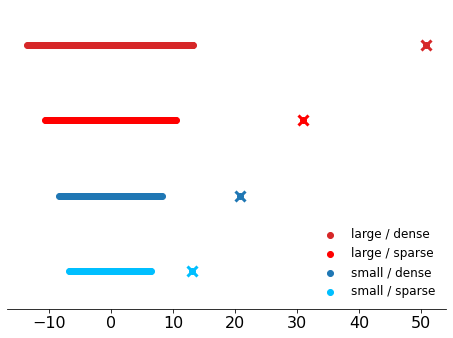

In [7]:
# Plot the eigenvalues of the four graphs
plt.figure()
ax = plt.axes()
ax.spines[['left','top','right']].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.scatter(evs4.real, 0.04 + evs4.imag, c=cols[3], label='large / dense')
plt.scatter(evs3.real, 0.03 + evs3.imag, c=cols[2], label='large / sparse')
plt.scatter(evs2.real, 0.02 + evs2.imag, c=cols[1], label='small / dense')
plt.scatter(evs1.real, 0.01 + evs1.imag, c=cols[0], label='small / sparse')

plt.scatter(evmax4, 0.04, marker='x', s=100, lw=3, c=cols[3])
plt.scatter(evmax3, 0.03, marker='x', s=100, lw=3, c=cols[2])
plt.scatter(evmax2, 0.02, marker='x', s=100, lw=3, c=cols[1])
plt.scatter(evmax1, 0.01, marker='x', s=100, lw=3, c=cols[0])

plt.ylim(0.005,0.045)
plt.tick_params( labelsize=16 )

plt.legend(frameon=False, loc='lower right', fontsize=12)
plt.tight_layout()


<br>

## 1. Properties of the original graphs (before normalization)


### Global response curves

1. Compute the pair-wise response matrices $\mathcal{R}_{ij}(t)$ over time.
2. Reduce to the global network response $r(t)$ (sum of all pair-wise responses, at every time point *t*).

In [8]:
# Define the simulation parameters
# Set the temporal resolution
tfinal = 0.6
dt = 0.005
tpoints = arange(0.0, tfinal+0.1*dt, dt)
nsteps = len(tpoints)

# Set the leakage time-constants τ, proportional to taumax
tauratio = 0.8
tau1 = tauratio * taumax1
tau2 = tauratio * taumax2
tau3 = tauratio * taumax3
tau4 = tauratio * taumax4

# Define the stimulation amplitude to every node
stim = 1.0


In [9]:
# Calculate temporal evolution of the pair-wise responses R(t)
print('\nCalculating ... pair-wise response tensors, from t=0 to t=%3.1f, with step=%3.3f ...' %(tfinal, dt) )
time1 = timer()
R1 = sna.Resp_LC(net1.T, tau=tau1, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
R2 = sna.Resp_LC(net2.T, tau=tau2, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
R3 = sna.Resp_LC(net3.T, tau=tau3, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
R4 = sna.Resp_LC(net4.T, tau=tau4, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )



Calculating pair-wise response tensors, from t=0 to t=0.6, with step=0.005 ...
14.545895729000001 seconds


In [10]:
# Compute the global network responses r(t) 
# (sum of all pair-wise responses, at every time-point)
r1 = sna.GlobalResponse(R1)
r2 = sna.GlobalResponse(R2)
r3 = sna.GlobalResponse(R3)
r4 = sna.GlobalResponse(R4)


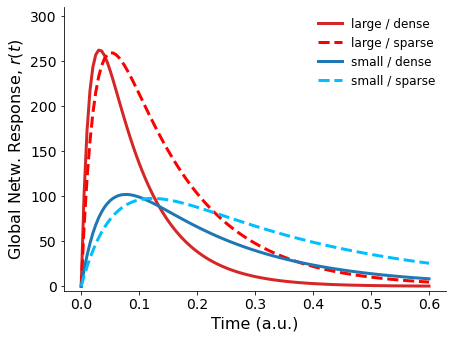

In [11]:
# Plot the global network responses
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.plot(tpoints, r4, lw=3, c=cols[3],           label='large / dense')
plt.plot(tpoints, r3, lw=3, c=cols[2], ls='--',  label='large / sparse')
plt.plot(tpoints, r2, lw=3, c=cols[1],           label='small / dense')
plt.plot(tpoints, r1, lw=3, c=cols[0], ls='--',  label='small / sparse')

plt.ylim(-5,310)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel('Global Netw. Response, $r(t)$', fontsize=16)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()


The global response curves $r(t)$ of the four networks follow different amplitudes and time scales. In the general case, for arbitrary networks, it would be difficult to identify whether such differences are due to differential internal architectures, or due to different sizes or densities. In this case, the four graphs were constructed following the same generative model, hence, their differences are due to the varying sizes and densities.

### Compare node responses to degrees

1. Compute the node responses over time $r_i(t)$, meaning the summed response of a node *i* to the stimuli applied at all other nodes *j = 1, 2, ..., N*.
2. Get the total node responses $\bar{r}_i$, meaning the integral (or area-under-the-curve) of curve $r_i(t)$ from $t=0$ to $t=t_\infty$. 
3. Plot $\bar{r}_i$ vs. degrees $k_i$.

In [12]:
# Extract the node response curves
r_nodes1 = sna.NodeResponses(R1)[0]
r_nodes2 = sna.NodeResponses(R2)[0]
r_nodes3 = sna.NodeResponses(R3)[0]
r_nodes4 = sna.NodeResponses(R4)[0]

# Integrate the node responses over time
totr_nodes1 = sna.AreaUnderCurve(r_nodes1, dt)
totr_nodes2 = sna.AreaUnderCurve(r_nodes2, dt)
totr_nodes3 = sna.AreaUnderCurve(r_nodes3, dt)
totr_nodes4 = sna.AreaUnderCurve(r_nodes4, dt)


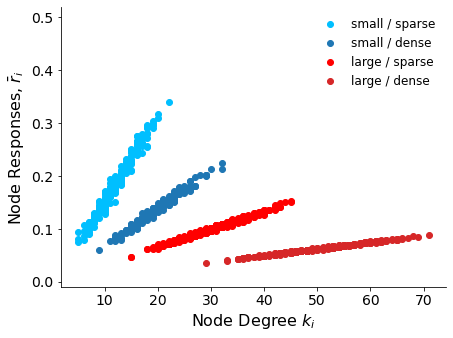

In [13]:
# Plot the degree - node response relations
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.scatter(indeg1, totr_nodes1, c=cols[0], label='small / sparse')
plt.scatter(indeg2, totr_nodes2, c=cols[1], label='small / dense')
plt.scatter(indeg3, totr_nodes3, c=cols[2], label='large / sparse')
plt.scatter(indeg4, totr_nodes4, c=cols[3], label='large / dense')

plt.ylim(-0.01,0.52)
plt.tick_params( labelsize=14 )
plt.xlabel( 'Node Degree $k_i$', fontsize=16 )
plt.ylabel( 'Node Responses, $\\bar{r}_i$', fontsize=16 )

plt.legend( frameon=False, fontsize=12 )
plt.tight_layout()


Total node responses follow linear relations with the degrees. The span of node response or degree values differs across network. In this case, given that the four networks were generated out of the same graph generative model, the differences are due to the varying sizes and densities.

<br>

## 2. Network properties after normalization

In the following, the four networks are normalized by their spectral radius such that $A' = A \,/\, \lambda_{max}$, and all the properties are recalculated using the normalised *A'* connectivity matrices.

### Normalize the matrices and compare their new eigenvalues

In [14]:
#### Normalize the four original networks by their corresponding spectral radius
nnet1 = net1 / evmax1
nnet2 = net2 / evmax2
nnet3 = net3 / evmax3
nnet4 = net4 / evmax4

# Compute the eigenvalues of the normalised networks
nevs1 = numpy.linalg.eigvals(nnet1)
nevs2 = numpy.linalg.eigvals(nnet2)
nevs3 = numpy.linalg.eigvals(nnet3)
nevs4 = numpy.linalg.eigvals(nnet4)

# Find the largest eigenvalues, and the new critical τ for each network
nevmax1 = SpectralRadius(nevs1); ntaumax1 = 1.0 / nevmax1
nevmax2 = SpectralRadius(nevs2); ntaumax2 = 1.0 / nevmax2
nevmax3 = SpectralRadius(nevs3); ntaumax3 = 1.0 / nevmax3
nevmax4 = SpectralRadius(nevs4); ntaumax4 = 1.0 / nevmax4

# Print some feedback: spectral radius and corresponding critical 'tau's
print( 'AFTER NORMALIZATION ...')
print( '\tSpectral radius\t\tLargest tau' )
print( 'net #1:   %3.5f\t\t%2.5f'  %(nevmax1, ntaumax1) )
print( 'net #2:   %3.5f\t\t%2.5f'  %(nevmax2, ntaumax2) )
print( 'net #3:   %3.5f\t\t%2.5f'  %(nevmax3, ntaumax3) )
print( 'net #4:   %3.5f\t\t%2.5f'  %(nevmax4, ntaumax4) )


AFTER NORMALIZATION ...
	Spectral radius		Largest tau
net #1:   1.00000		1.00000
net #2:   1.00000		1.00000
net #3:   1.00000		1.00000
net #4:   1.00000		1.00000


The normalization makes the spectral radii of the four networks to align, $\lambda_{max} = 1.0$, implying that the growth rates carried by the terms $A' \mathbf{x}$ to be now equal. Therefore, the largest admisible leakage time-constants $\tau_{max} = 1 \,/\,\lambda_{max} = 1.0$ are equal as well.

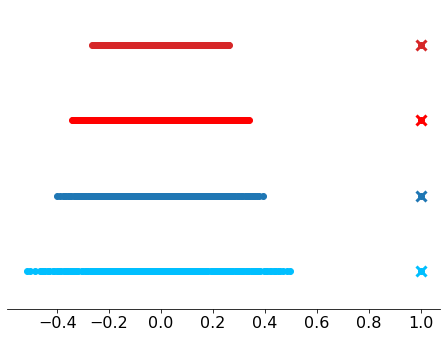

In [15]:
# Plot the eigenvalues of the normalized graphs
plt.figure()
ax = plt.axes()
ax.spines[['left','top','right']].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.scatter(nevs1.real, 0.01 + nevs1.imag, c=cols[0], label='small / sparse')
plt.scatter(nevs2.real, 0.02 + nevs2.imag, c=cols[1], label='small / dense')
plt.scatter(nevs3.real, 0.03 + nevs3.imag, c=cols[2], label='large / sparse')
plt.scatter(nevs4.real, 0.04 + nevs4.imag, c=cols[3], label='large / dense')

plt.scatter(nevmax1, 0.01, marker='x', s=100, lw=3, c=cols[0])
plt.scatter(nevmax2, 0.02, marker='x', s=100, lw=3, c=cols[1])
plt.scatter(nevmax3, 0.03, marker='x', s=100, lw=3, c=cols[2])
plt.scatter(nevmax4, 0.04, marker='x', s=100, lw=3, c=cols[3])

plt.ylim(0.005,0.045)
plt.tick_params( labelsize=16 )

#plt.legend(frameon=False, loc='lower right', fontsize=12)
plt.tight_layout()



### Global response curves

In [16]:
# Define the simulation parameters
# Set the temporal resolution
ntfinal = 12
ndt = 0.05
ntpoints = arange(0.0, ntfinal+0.1*ndt, ndt)

# Set the leakage time-constants τ, proportional to taumax.
# After normalization all taumax = 1.0, hence, we only need one value for all four networks.
ntau = 0.8

# Define the stimulation amplitude to every node
stim = 1.0


In [18]:
# Calculate temporal evolution of the pair-wise responses R(t)
print('\nCalculating ... pair-wise response tensors, from t=0 to t=%3.1f, with step=%3.3f ...' %(tfinal, dt) )
time1 = timer()
nR1 = sna.Resp_LC(nnet1.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nR2 = sna.Resp_LC(nnet2.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nR3 = sna.Resp_LC(nnet3.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nR4 = sna.Resp_LC(nnet4.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )



Calculating ... pair-wise response tensors, from t=0 to t=0.6, with step=0.005 ...
24.958180167999984 seconds


In [19]:
# Compute the global network responses r(t) 
# (sum of all pair-wise responses, at every time-point)
nr1 = sna.GlobalResponse(nR1)
nr2 = sna.GlobalResponse(nR2)
nr3 = sna.GlobalResponse(nR3)
nr4 = sna.GlobalResponse(nR4)


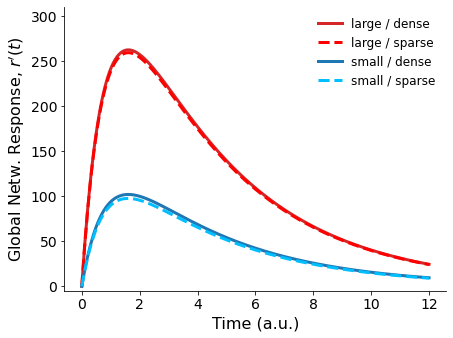

In [21]:
# Plot the global network responses
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.plot(ntpoints, nr4, lw=3, c=cols[3],           label='large / dense')
plt.plot(ntpoints, nr3, lw=3, c=cols[2], ls='--',  label='large / sparse')
plt.plot(ntpoints, nr2, lw=3, c=cols[1],           label='small / dense')
plt.plot(ntpoints, nr1, lw=3, c=cols[0], ls='--',  label='small / sparse')

plt.ylim(-5,310)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel("Global Netw. Response, $r'(t)$", fontsize=16)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()


Now, the normalized global response curves $r'(t)$ are temporally aligned. The only differences are the amplitudes which depend on the number of nodes *N* because, at each time *t*, $r'(t)$ are the sum of all the elements in the response matrix $\mathcal{R}'_{ij}(t)$. As a consequence, the curves align in pairs, for the two large and the two small networks.

Further normalizing as $r'(t) \,/\, N$ makes all responses to completely align.

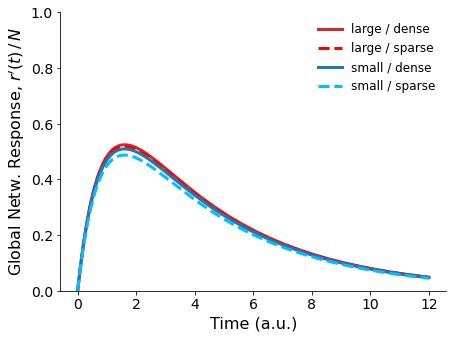

In [22]:
# Plot the global network responses, further normalized by network sizes
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.plot(ntpoints, nr4 / N2, lw=3, c=cols[3],           label='large / dense')
plt.plot(ntpoints, nr3 / N2, lw=3, c=cols[2], ls='--',  label='large / sparse')
plt.plot(ntpoints, nr2 / N1, lw=3, c=cols[1],           label='small / dense')
plt.plot(ntpoints, nr1 / N1, lw=3, c=cols[0], ls='--',  label='small / sparse')

plt.ylim(0,1)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel("Global Netw. Response, $r'(t) \,/\, N$", fontsize=16)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()


Small differences may be observed for the '*Random*' and the '*ScaleFree*' cases because each generated network is one independent instance of the graph generative models. Averaging over many realizations would perfectly align the four curves.

### Compare node responses to degrees

In [23]:
# Extract the node response curves
nr_nodes1 = sna.NodeResponses(nR1)[0]
nr_nodes2 = sna.NodeResponses(nR2)[0]
nr_nodes3 = sna.NodeResponses(nR3)[0]
nr_nodes4 = sna.NodeResponses(nR4)[0]

# Integrate the node responses over time
ntotr_nodes1 = sna.AreaUnderCurve(nr_nodes1, ndt)
ntotr_nodes2 = sna.AreaUnderCurve(nr_nodes2, ndt)
ntotr_nodes3 = sna.AreaUnderCurve(nr_nodes3, ndt)
ntotr_nodes4 = sna.AreaUnderCurve(nr_nodes4, ndt)


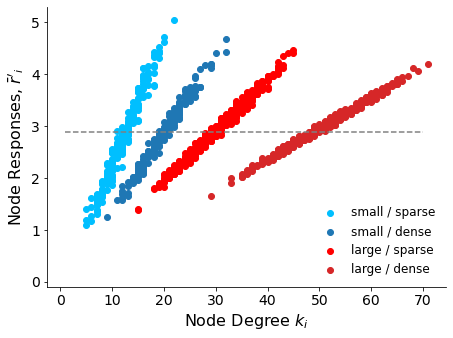

In [24]:
# Plot the degree - node response relations
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.scatter(indeg1, ntotr_nodes1, c=cols[0], label='small / sparse')
plt.scatter(indeg2, ntotr_nodes2, c=cols[1], label='small / dense')
plt.scatter(indeg3, ntotr_nodes3, c=cols[2], label='large / sparse')
plt.scatter(indeg4, ntotr_nodes4, c=cols[3], label='large / dense')

avntotr = mean( (ntotr_nodes1.mean(), ntotr_nodes4.mean(), ntotr_nodes4.mean(), ntotr_nodes4.mean()) )
plt.plot((1,70),(avntotr,avntotr), '--', color='gray')

maxylim = max( ntotr_nodes1.max(),ntotr_nodes2.max(),ntotr_nodes3.max(),ntotr_nodes4.max() )
plt.ylim(-0.02*maxylim, 1.05*maxylim)

plt.tick_params( labelsize=14 )
plt.xlabel( 'Node Degree $k_i$', fontsize=16 )
plt.ylabel( "Node Responses, $\\bar{r}'_i$", fontsize=16 )

plt.legend( frameon=False, fontsize=12 )
plt.tight_layout()


Again, the linear relations between degrees and node responses are observed. However, after the normalization, the ranges of values for the node response $\bar{r}'_i$ of the four networks become aligned (dashed gray line marking their average), while the ranges of degrees still depend on the size and density of each network. Therefore, after normalization, the distributions of $\bar{r}_i$ values become directly comparable.